In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Embedding, Dot
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, PReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from functools import partial

In [5]:
from sklearn.metrics import make_scorer

def smape(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    epsilon = 0.001
    default = 0.5
    
    numerator = np.abs(actual_values - predicted_values)
    denominator = np.maximum(np.abs(actual_values) + np.abs(predicted_values) + epsilon, default)
    
    abs_percent = numerator / denominator

    sym_mean_abs_percent = - abs_percent.mean() * 100
    
    return sym_mean_abs_percent

smape_scorer = make_scorer(smape)
smape_scorer

make_scorer(smape)

# Data load

In [6]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# Column 설정

In [7]:
target = 'sales'

In [8]:
columns_useless = ['id']

In [9]:
columns_num_all = joblib.load('columns_num.pkl')
columns_cat_all = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')
columns_dt = joblib.load('columns_dt.pkl')

In [10]:
try :
    columns_num_all.remove(target)
    
except :
    pass

In [11]:
try :
    columns_cat_all.remove(target)
    
except :
    pass

In [12]:
columns_num = []

for column in columns_num_all :
    
    if column not in columns_useless :
        columns_num.append(column)
        
columns_num

[]

In [13]:
columns_cat = []

for column in columns_cat_all :
    
    if column not in columns_useless :
        columns_cat.append(column)
        
columns_cat

['store', 'item']

In [14]:
columns_sc = []

for column in columns_num :
    
    if column not in columns_binary_num:
        columns_sc.append(column)
        
columns_sc

[]

In [15]:
# columns_sc.remove('date_block_num')

In [16]:
columns_en = []

for column in columns_cat :
    
    if (column not in columns_binary_num) and (column not in columns_binary_cat):
        columns_en.append(column)
        
columns_en

['store', 'item']

# Target 분리

In [17]:
y_train = train[target]
X_train = train.drop(target, axis=1)
X_train_og = X_train.copy()

In [18]:
X_test = test.copy()

# 전체 dataset concat

In [19]:
all_data = pd.concat([X_train, X_test])

# Data preprocessing

In [20]:
def date_features(data, column):
    data['year'] = data[column].dt.year
    data['quarter'] = data[column].dt.quarter
    data['month'] = data[column].dt.month   # Data preprocessing 때 string으로 변환해야함
    data['day'] = data[column].dt.day
    data['day_of_week'] = data[column].dt.dayofweek   # Monday = 0, Sunday = 6
    data['is_weekend'] = data[column].dt.weekday // 5
    
    data.drop(column, axis=1, inplace=True)
    
    date_columns = data.columns[-6:].to_list()
    other_columns = data.columns[:-6].to_list()
    columns = date_columns + other_columns
    
    data = data[columns]
    
    return data

In [21]:
def preprocessing(data, X_data_og, columns_useless, columns_sc, columns_binary_cat, columns_en) :
    
    # datetime 변환
    data = date_features(data, 'date')
    
    columns_num.extend(['year'])
    columns_en.extend(['quarter', 'month', 'day', 'day_of_week', 'is_weekend'])
    
    # useless column 제거
    try :
        data.drop(columns_useless, axis=1, inplace=True)

    except :
        pass
    
    # scaling
#     scaler = StandardScaler()
#     scaler.fit(X_data_og[columns_sc])
#     data[columns_sc] = scaler.transform(data[columns_sc])
   
    # One-hot-encoding
    data = pd.get_dummies(data, columns=columns_en)
#     encoder = OneHotEncoder()   # 고윳값을 많이 가진 feature가 있는 경우는 OneHotEncoder를 사용해야 함
#     data = encoder.fit_transform(data)
    
    return data

In [22]:
all_data = preprocessing(all_data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)

# Train & test set 분리

In [23]:
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

# Sampling
- dataset이 너무 크기 때문에 sampling 진행

In [24]:
# train_sp = train.sample(frac=0.01, random_state=30)

In [25]:
X_train, X_left, y_train, y_letf = train_test_split(X_train, y_train, train_size=0.1, random_state=30)

# Validation set 분리
- Train dataset이 너무 커서 cross validation에 너무 오랜 시간이 걸리는 경우
- OneHotEncoder를 사용하면 sparse matrix를 return하기 때문에 neural network에서 validation_split를 사용할 수 없는 경우

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=30)

In [27]:
X_train.shape, y_train.shape

((68475, 117), (68475,))

In [28]:
X_val.shape, y_val.shape

((22825, 117), (22825,))

# ML model cross validation

In [29]:
knn = KNeighborsRegressor(n_neighbors=5)
linear = LinearRegression()
ridge = Ridge(alpha=1, random_state=30)
lasso = Lasso(alpha=1, random_state=30)
elastic = ElasticNet(alpha=1, l1_ratio=0.5, random_state=30)
sgd = SGDRegressor(max_iter=1000, eta0=0.01, penalty='l2', random_state=30)
svm = SVR(kernel='rbf', C=1.0, gamma='scale')
dt = DecisionTreeRegressor(max_depth=None, random_state=30)
rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=30)
et = ExtraTreesRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=30)
gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, max_depth=3, random_state=30)
xgb = XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, n_jobs=-1, random_state=30)
# lgb = LGBMRegressor(random_state=30)
adb = AdaBoostRegressor(random_state=30)
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, max_iter=200,
                    learning_rate='constant', learning_rate_init=0.001, random_state=30)

In [30]:
models = {
    'knn' : knn,
    'linear' : linear,
    'ridge' : ridge,
    'lasso' : lasso,
    'elastic' : elastic,
    'sgd' : sgd,
    'svm' : svm,
    'dt' : dt,
    'rf' : rf,
    'et' : et,
    'gb' : gb,
    'xgb' : xgb,
#     'lgb' : lgb,
    'adb' : adb,
    'mlp' : mlp
}

In [31]:
# result = []

# for key, model in models.items() : 
#     score = cross_validate(model, X_train, y_train, cv=5, scoring=smape_scorer, return_train_score=True, n_jobs=-1)  
#     score = pd.DataFrame(score).mean()
#     score = - score
    
#     result.append(score)
    
#     print(key)

In [32]:
# result = pd.concat(result, axis=1)
# result.columns = models.keys()
# result = result.T
# result = result[['test_score', 'train_score', 'fit_time', 'score_time']]
# result = round(result, 3)
# result

In [33]:
# result.to_csv('result.csv')

In [34]:
result = pd.read_csv('ML_result.csv', index_col=0)
result

,test_score,train_score,fit_time,score_time
knn,18.030,15.057,-25.675,-332.871
linear,11.559,11.540,-2.219,-0.111
ridge,11.547,11.528,-0.618,-0.065
lasso,21.452,21.448,-0.793,-0.052
elastic,22.052,22.050,-0.806,-0.079
sgd,100.000,100.000,-2.846,-0.048
svm,23.033,23.033,-1354.701,-297.162
dt,10.071,0.000,-4.764,-0.042
rf,7.483,2.882,-247.605,-2.134
et,8.731,0.000,-389.343,-1.515


In [35]:
# for key, model in models.items() :
#     model.fit(X_train, y_train)
#     print(key, ':', round(model.score(X_val, y_val), 3))

- knn : 0.415
- linear : 0.867
- ridge : 0.867
- lasso : 0.178
- elastic : 0.125
- sgd : -7.121322175320087e+25
- dt : 0.831
- rf : 0.906
- et : 0.873
- gb : 0.909
- xgb : 0.686
- adb : 0.146
- mlp : 0.832

- 회귀에서 score는 R2 score를 반환

# Nerual network

In [36]:
def plot_result(history) :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b--', label='loss')
    plt.plot(history.history['val_loss'], 'r-', label='val_loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mape'], 'b--', label='mape')
    plt.plot(history.history['val_mape'], 'r-', label='val_mape')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

In [37]:
np.random.seed(30)
tf.random.set_seed(30)

In [38]:
model = Sequential()
model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)))

for layer in range(5):
    model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11800     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [39]:
type(X_train)

pandas.core.frame.DataFrame

In [40]:
# Keras can't work with csr_matrix. Convert to a numpy array.
# X_train = X_train.toarray()
# X_val = X_val.toarray()

In [41]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [42]:
model.compile(loss='mse', optimizer=optimizer, metrics=['mape'])

In [43]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [44]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
2140/2140 [==============================] - 9s 4ms/step - loss: 556.5522 - mape: 49.9229 - val_loss: 124.8026 - val_mape: 19.9727
Epoch 2/100
2140/2140 [==============================] - 8s 4ms/step - loss: 130.5861 - mape: 20.5733 - val_loss: 101.1075 - val_mape: 18.8110
Epoch 3/100
2140/2140 [==============================] - 8s 4ms/step - loss: 124.4476 - mape: 19.5352 - val_loss: 96.5901 - val_mape: 17.3388
Epoch 4/100
2140/2140 [==============================] - 8s 4ms/step - loss: 114.0583 - mape: 18.4651 - val_loss: 104.1294 - val_mape: 16.0602
Epoch 5/100
2140/2140 [==============================] - 8s 4ms/step - loss: 111.6070 - mape: 18.3366 - val_loss: 133.1401 - val_mape: 17.5172
Epoch 6/100
2140/2140 [==============================] - 8s 4ms/step - loss: 110.5189 - mape: 18.1729 - val_loss: 148.2396 - val_mape: 17.8911
Epoch 7/100
2140/2140 [==============================] - 8s 4ms/step - loss: 112.0246 - mape: 18.2572 - val_loss: 111.7421 - val_mape: 21.2168


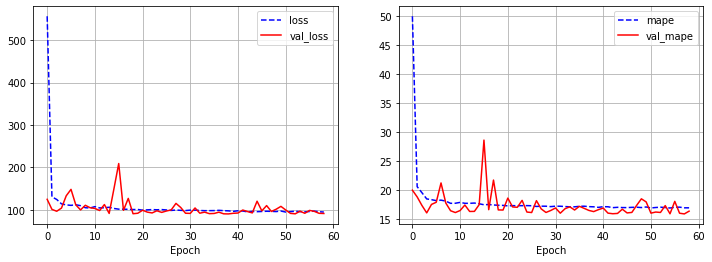

In [45]:
plot_result(history)